# <b><u> Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Task is to build a model that predicts the total ride duration of taxi trips in New York City. Dataset is released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import great_circle
%matplotlib inline

In [3]:
data_path = '/content/drive/MyDrive/AlmaBetter/CapstoneProjects/Supervised ML Regression/nyc_taxi_data.csv'
taxi_df = pd.read_csv(data_path)

Checkout sample data

In [4]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
taxi_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [6]:
taxi_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

pickup_datetime and dropoff_datetime are in object datatypes. We should convert it to datetime object.

In [7]:
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime'])
taxi_df['dropoff_datetime'] = pd.to_datetime(taxi_df['dropoff_datetime'])

Check for missing/null values

In [8]:
taxi_df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no null values in the dataset. So, there is no need for imputation


Check for the statistics of the dataset

In [9]:
taxi_df.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644,1.458644e+06
unique,1458644,NaN,1380222,1380377,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id2875421,NaN,2016-03-04 08:07:34,2016-02-19 19:25:04,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,5,5,NaN,NaN,NaN,NaN,NaN,1450599,NaN
first,NaN,NaN,2016-01-01 00:00:17,2016-01-01 00:03:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-06-30 23:59:39,2016-07-01 23:02:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.534950e+00,NaN,NaN,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,NaN,9.594923e+02
std,NaN,4.987772e-01,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,NaN,5.237432e+03
min,NaN,1.000000e+00,NaN,NaN,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,NaN,1.000000e+00
25%,NaN,1.000000e+00,NaN,NaN,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,NaN,3.970000e+02


## Feature Engineering

We can use pickup_datetime and dropoff_datetime to extract Day Name, Week day, Hour and Month 

In [10]:
taxi_df['pickup_day'] = taxi_df['pickup_datetime'].dt.day_name()
taxi_df['dropoff_day'] = taxi_df['dropoff_datetime'].dt.day_name()
taxi_df['pickup_day_no'] = taxi_df['pickup_datetime'].dt.weekday
taxi_df['dropoff_day_no'] = taxi_df['dropoff_datetime'].dt.weekday
taxi_df['pickup_hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['dropoff_hour'] = taxi_df['dropoff_datetime'].dt.hour
taxi_df['pickup_month'] = taxi_df['pickup_datetime'].dt.month
taxi_df['dropoff_month'] = taxi_df['dropoff_datetime'].dt.month

The following features are created:

* pickup_day and dropoff_day which will contain the name of the day on which the ride was taken.

* pickup_day_no and dropoff_day_no which will contain the day number instead of characters with Monday=0 and Sunday=6.

* pickup_hour and dropoff_hour with an hour of the day in the 24-hour format.

* pickup_month and dropoff_month with month number with January=1 and December=12.

Create a new feature time of the day to determine what time of the day the ride was taken.

In [11]:
def time_of_day(x):
    if x in range(6, 12):
        return 'Morning'
    elif x in range(12, 16):
        return 'Afternoon'
    elif x in range(16, 22):
        return 'Evening'
    else:
        return 'Late night'

taxi_df['pickup_timeofday'] = taxi_df['pickup_hour'].apply(time_of_day)
taxi_df['dropoff_timeofday'] = taxi_df['dropoff_hour'].apply(time_of_day)

Create a new feature to get the distance from pickup and drop latitudes and longitudes 

In [12]:
def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
    start_coordinates=(pickup_lat,pickup_long)
    stop_coordinates=(dropoff_lat,dropoff_long)
 
    return great_circle(start_coordinates,stop_coordinates).km

taxi_df['distance'] = taxi_df.apply(lambda x: cal_distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude'] ), axis=1)

Analysing the Target variable

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


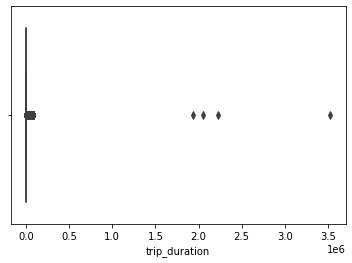

In [13]:
sns.boxplot(taxi_df['trip_duration'])

As we can see, there are outliers. We can drop these 4 outliers for our analysis 

In [14]:
taxi_df['trip_duration'].sort_values(ascending=False)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
            ...   
269418           1
467645           1
533799           1
726971           1
311745           1
Name: trip_duration, Length: 1458644, dtype: int64

In [15]:
taxi_df.drop(taxi_df[taxi_df['trip_duration'] == 3526282].index, inplace=True)
taxi_df.drop(taxi_df[taxi_df['trip_duration'] == 2227612].index, inplace=True)
taxi_df.drop(taxi_df[taxi_df['trip_duration'] == 2049578].index, inplace=True)
taxi_df.drop(taxi_df[taxi_df['trip_duration'] == 1939736].index, inplace=True)

## Exploratory Data Analysis

Correlation heat map

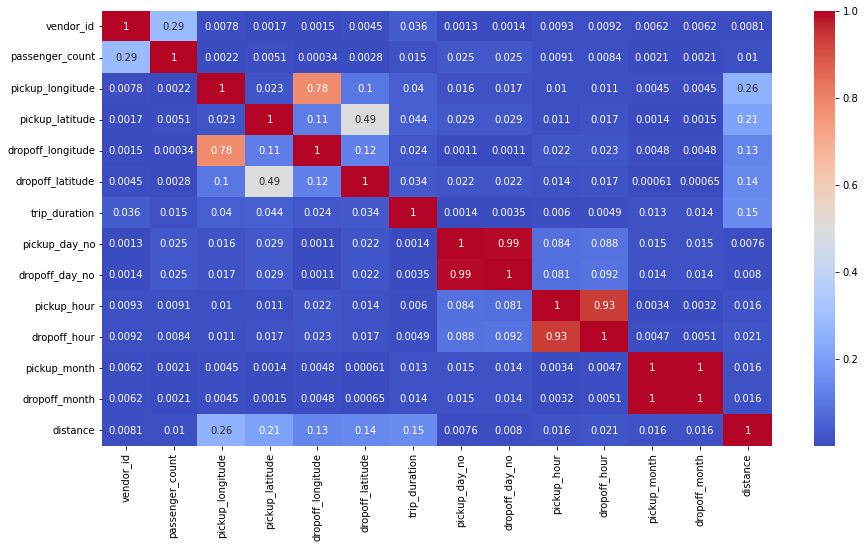

In [16]:
plt.figure(figsize=(15, 8))
corr = taxi_df.corr()
sns.heatmap(abs(corr), annot=True, cmap='coolwarm')

Pickup latitude and dropoff latitude, pickup longitude and dropoff longitude, pickup day no and dropoff day no, pickup hour and dropoff hour are correlated.

Analysing Vendor id

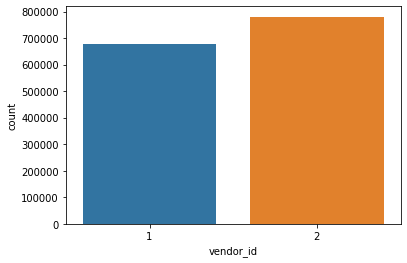

In [17]:
sns.countplot(x='vendor_id', data=taxi_df)

Analysing Passenger count

In [18]:
taxi_df.passenger_count.value_counts()

1    1033537
2     210317
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [19]:
taxi_df = taxi_df[taxi_df['passenger_count'] != 0]
taxi_df = taxi_df[taxi_df['passenger_count'] <= 6]

In [20]:
taxi_df.passenger_count.value_counts()

1    1033537
2     210317
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

Analyse Store and fwd flag

In [21]:
taxi_df['store_and_fwd_flag'].value_counts(normalize=True)

N    0.994486
Y    0.005514
Name: store_and_fwd_flag, dtype: float64

Analyse Distance

In [22]:
taxi_df['distance'].value_counts()

0.000000    5887
0.000424      45
0.000424      43
0.000424      35
0.000424      22
            ... 
3.231345       1
1.584861       1
0.434274       1
3.809274       1
1.134044       1
Name: distance, Length: 1452305, dtype: int64

Analysing Trips per day

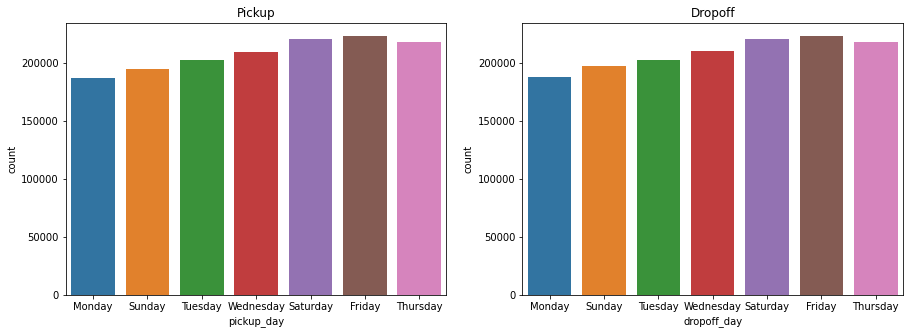

In [23]:
figure,(ax1,ax2) = plt.subplots(ncols=2, figsize=(15, 5))

ax1.set_title('Pickup')
ax = sns.countplot(x="pickup_day", data=taxi_df, ax=ax1)

ax2.set_title('Dropoff')
ax = sns.countplot(x="dropoff_day", data=taxi_df, ax=ax2)

Analysing Trips per hour

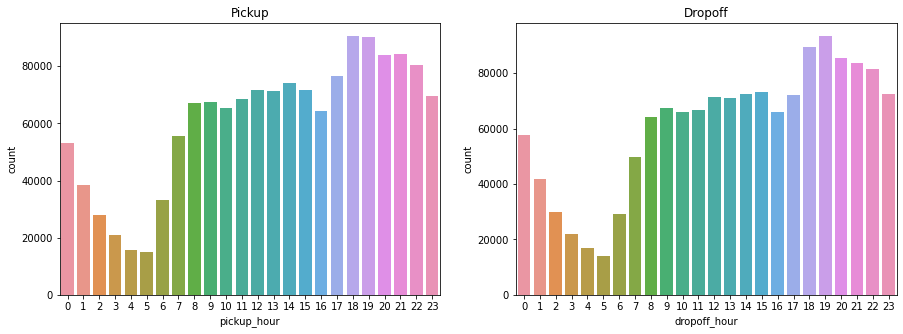

In [24]:
figure,(ax1,ax2) = plt.subplots(ncols=2, figsize=(15, 5))

ax1.set_title('Pickup')
ax = sns.countplot(x="pickup_hour", data=taxi_df, ax=ax1)

ax2.set_title('Dropoff')
ax = sns.countplot(x="dropoff_hour", data=taxi_df, ax=ax2)

Analysing Trips per time of day

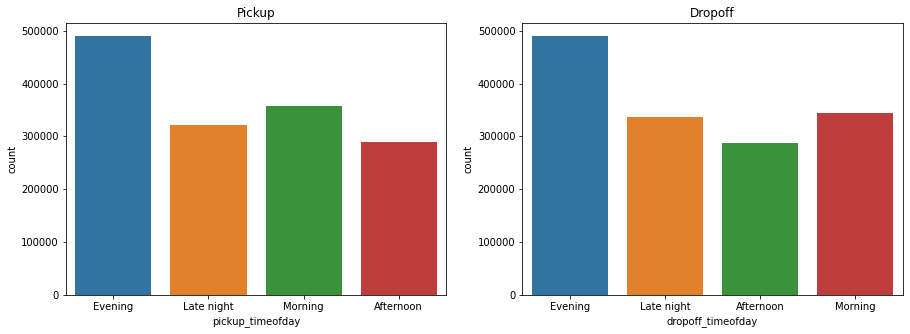

In [25]:
figure,(ax1,ax2) = plt.subplots(ncols=2, figsize=(15, 5))

ax1.set_title('Pickup')
ax = sns.countplot(x="pickup_timeofday", data=taxi_df, ax=ax1)

ax2.set_title('Dropoff')
ax = sns.countplot(x="dropoff_timeofday", data=taxi_df, ax=ax2)

Analysing Trips per month

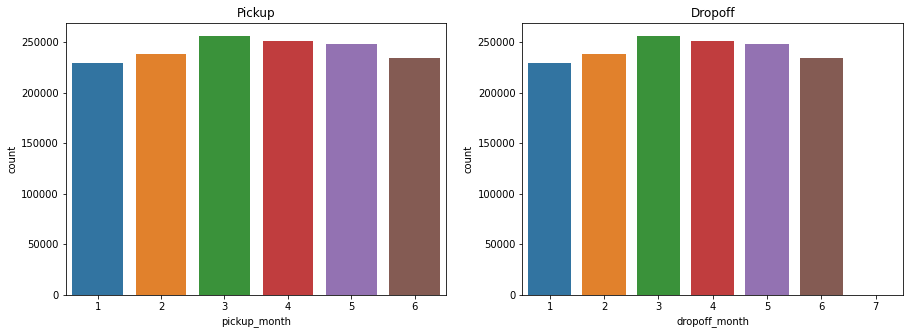

In [26]:
figure,(ax1,ax2) = plt.subplots(ncols=2, figsize=(15, 5))

ax1.set_title('Pickup')
ax = sns.countplot(x="pickup_month", data=taxi_df, ax=ax1)

ax2.set_title('Dropoff')
ax = sns.countplot(x="dropoff_month", data=taxi_df, ax=ax2)

Analysing Trip duration for each vendor

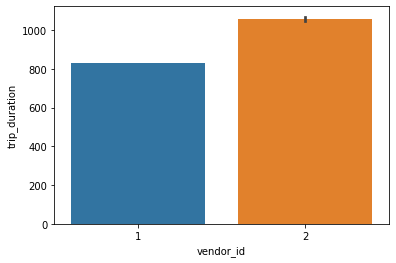

In [27]:
sns.barplot(y='trip_duration', x='vendor_id', data=taxi_df, estimator=np.mean)

Analysing Trip duration per hour

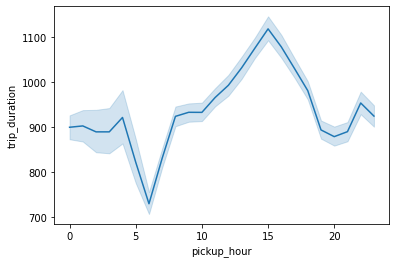

In [28]:
sns.lineplot(x='pickup_hour', y='trip_duration', data=taxi_df)

Analysing distance per hour of day

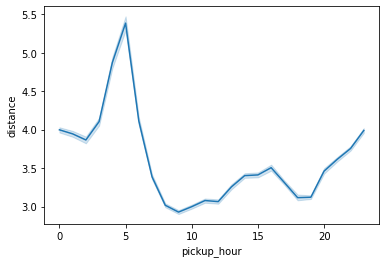

In [29]:
sns.lineplot(x='pickup_hour', y='distance', data=taxi_df)

In [30]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_day,pickup_day_no,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_timeofday,dropoff_timeofday,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,0,0,17,17,3,3,Evening,Evening,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,6,6,0,0,6,6,Late night,Late night,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,1,1,11,12,1,1,Morning,Afternoon,6.385108
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2,2,19,19,4,4,Evening,Evening,1.485501
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,5,5,13,13,3,3,Afternoon,Afternoon,1.188590


In [31]:
taxi_df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
pickup_day                    object
dropoff_day                   object
pickup_day_no                  int64
dropoff_day_no                 int64
pickup_hour                    int64
dropoff_hour                   int64
pickup_month                   int64
dropoff_month                  int64
pickup_timeofday              object
dropoff_timeofday             object
distance                     float64
dtype: object

Convert categorical variables pickup_timeofday and dropoff_timeofday to dummy variables





In [32]:
taxi_newdf = pd.get_dummies(data=taxi_df, columns=["store_and_fwd_flag", "vendor_id"])

In [33]:
taxi_newdf.head()

,id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,...,dropoff_hour,pickup_month,dropoff_month,pickup_timeofday,dropoff_timeofday,distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,vendor_id_1,vendor_id_2
0,id2875421,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,Monday,...,17,3,3,Evening,Evening,1.498523,1,0,0,1
1,id2377394,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,Sunday,...,0,6,6,Late night,Late night,1.805510,1,0,1,0
2,id3858529,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,Tuesday,...,12,1,1,Morning,Afternoon,6.385108,1,0,0,1
3,id3504673,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,Wednesday,...,19,4,4,Evening,Evening,1.485501,1,0,0,1
4,id2181028,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,Saturday,...,13,3,3,Afternoon,Afternoon,1.188590,1,0,0,1


## Model Training

In [34]:
taxi_newdf.columns

Index(['id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'pickup_day', 'dropoff_day',
       'pickup_day_no', 'dropoff_day_no', 'pickup_hour', 'dropoff_hour',
       'pickup_month', 'dropoff_month', 'pickup_timeofday',
       'dropoff_timeofday', 'distance', 'store_and_fwd_flag_N',
       'store_and_fwd_flag_Y', 'vendor_id_1', 'vendor_id_2'],
      dtype='object')

### Linear Regression

In [35]:
label = ['trip_duration']
#features = ['vendor_id', 'passenger_count', 'trip_duration', 'pickup_day_no', 'dropoff_day_no',
#            'pickup_hour', 'dropoff_hour', 'pickup_month', 'dropoff_month', 'distance']

features = ['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'pickup_hour',
       'pickup_day_no', 'pickup_month', 'dropoff_day_no', 'store_and_fwd_flag_Y',
       'vendor_id_2']

In [36]:
x = taxi_newdf[features]
y = taxi_newdf[label]

In [37]:
from sklearn.model_selection import train_test_split, ShuffleSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, np.log(y.values + 1), test_size=0.15, random_state=33)
# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=33)

In [39]:
scores = []

### Linear Regression

In [40]:
linear_regression = LinearRegression()
parameters = {}
rs =  RandomizedSearchCV(linear_regression, parameters, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
rs.fit(x_train, y_train)

y_pred = rs.predict(x_test)
best_score = rs.best_score_
r2_score_ = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
best_params = rs.best_params_

print("Best Score:", best_score)
print("R2 score:", r2_score_)
print("MSE:", mse)
print("Best Parameter:", best_params)

scores.append({'Model': 'Linear Regression',
                 'Best Score': best_score,
                 'R2 Score': r2_score_,
                 'MSE': mse,
                 'Best Parameter': best_params})

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score: 0.3726967888011929
R2 score: 0.3702806066309863
MSE: 0.39922939908546595
Best Parameter: {}


### Lasso Regression

In [41]:
lasso_regression = Lasso()
parameters = {'alpha': [0.1, 0.01, 0.001], 'max_iter': [1000, 2000]}
rs =  RandomizedSearchCV(lasso_regression, parameters, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
rs.fit(x_train, y_train)

y_pred = rs.predict(x_test)
best_score = rs.best_score_
r2_score_ = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
best_params = rs.best_params_

print("Best Score:", best_score)
print("R2 score:", r2_score_)
print("MSE:", mse)
print("Best Parameter:", best_params)

scores.append({'Model': 'Lasso Regression',
                 'Best Score': best_score,
                 'R2 Score': r2_score_,
                 'MSE': mse,
                 'Best Parameter': best_params})

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best Score: 0.372673422443186
R2 score: 0.37004752943574126
MSE: 0.39937716532798284
Best Parameter: {'max_iter': 1000, 'alpha': 0.001}


### Ridge Regression

In [42]:
ridge_regression = Ridge()
parameters = {'alpha': [1, 0.1, 0.01, 0.001]}
rs =  RandomizedSearchCV(ridge_regression, parameters, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
rs.fit(x_train, y_train)

y_pred = rs.predict(x_test)
best_score = rs.best_score_
r2_score_ = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
best_params = rs.best_params_

print("Best Score:", best_score)
print("R2 score:", r2_score_)
print("MSE:", mse)
print("Best Parameter:", best_params)

scores.append({'Model': 'Ridge Regression',
                 'Best Score': best_score,
                 'R2 Score': r2_score_,
                 'MSE': mse,
                 'Best Parameter': best_params})

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best Score: 0.3726967887402468
R2 score: 0.37028060655457773
MSE: 0.3992293991339074
Best Parameter: {'alpha': 0.001}


### Decision Tree Regressor

In [43]:
ds_regressor = DecisionTreeRegressor()
parameters = {'criterion' : ['squared_error','friedman_mse'], 'splitter': ['best','random']}
rs =  RandomizedSearchCV(ds_regressor, parameters, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
rs.fit(x_train, y_train)

y_pred = rs.predict(x_test)
best_score = rs.best_score_
r2_score_ = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
best_params = rs.best_params_

print("Best Score:", best_score)
print("R2 score:", r2_score_)
print("MSE:", mse)
print("Best Parameter:", best_params)

scores.append({'Model': 'Decision Tree Regressor',
                 'Best Score': best_score,
                 'R2 Score': r2_score_,
                 'MSE': mse,
                 'Best Parameter': best_params})

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best Score: 0.5097079236922772
R2 score: 0.5103090235663305
MSE: 0.31045420598095996
Best Parameter: {'splitter': 'best', 'criterion': 'squared_error'}


In [44]:
scores

[{'Best Parameter': {},
  'Best Score': 0.3726967888011929,
  'MSE': 0.39922939908546595,
  'Model': 'Linear Regression',
  'R2 Score': 0.3702806066309863},
 {'Best Parameter': {'alpha': 0.001, 'max_iter': 1000},
  'Best Score': 0.372673422443186,
  'MSE': 0.39937716532798284,
  'Model': 'Lasso Regression',
  'R2 Score': 0.37004752943574126},
 {'Best Parameter': {'alpha': 0.001},
  'Best Score': 0.3726967887402468,
  'MSE': 0.3992293991339074,
  'Model': 'Ridge Regression',
  'R2 Score': 0.37028060655457773},
 {'Best Parameter': {'criterion': 'squared_error', 'splitter': 'best'},
  'Best Score': 0.5097079236922772,
  'MSE': 0.31045420598095996,
  'Model': 'Decision Tree Regressor',
  'R2 Score': 0.5103090235663305}]

### Random Forest Regressor

In [45]:
rs = RandomForestRegressor(n_estimators=50, min_samples_leaf=10, min_samples_split=15, max_features='auto', max_depth=50, bootstrap=True)
rs.fit(x_train, y_train)

y_pred = rs.predict(x_test)
y_pred_train = rs.predict(x_train)
best_score = r2_score(y_train, y_pred_train)
r2_score_ = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
best_params = "{'bootstrap': True, 'max_features': 'auto', 'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 50}"

print("Best Score:", best_score)
print("R2 score:", r2_score_)
print("MSE:", mse)

scores.append({'Model': 'Random Forest Regressor',
                 'Best Score': best_score,
                 'R2 Score': r2_score_,
                 'MSE': mse,
                 'Best Parameter': best_params})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Best Score: 0.8294088744616425
R2 score: 0.7467622625230015
MSE: 0.16054761981811919


In [46]:
model_df = pd.DataFrame(scores, columns=['Model', 'Best Score', 'R2 Score', 'MSE', 'Best Parameter'])

In [48]:
model_df

,Model,Best Score,R2 Score,MSE,Best Parameter
0,Linear Regression,0.372697,0.370281,0.399229,{}
1,Lasso Regression,0.372673,0.370048,0.399377,"{'max_iter': 1000, 'alpha': 0.001}"
2,Ridge Regression,0.372697,0.370281,0.399229,{'alpha': 0.001}
3,Decision Tree Regressor,0.509708,0.510309,0.310454,"{'splitter': 'best', 'criterion': 'squared_err..."
4,Random Forest Regressor,0.829409,0.746762,0.160548,"{'bootstrap': True, 'max_features': 'auto', 'm..."
